In [1]:
from __future__ import print_function, unicode_literals, division
import warnings
warnings.filterwarnings(action='ignore')

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import applications
from tensorflow.keras.utils import plot_model


%matplotlib inline
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

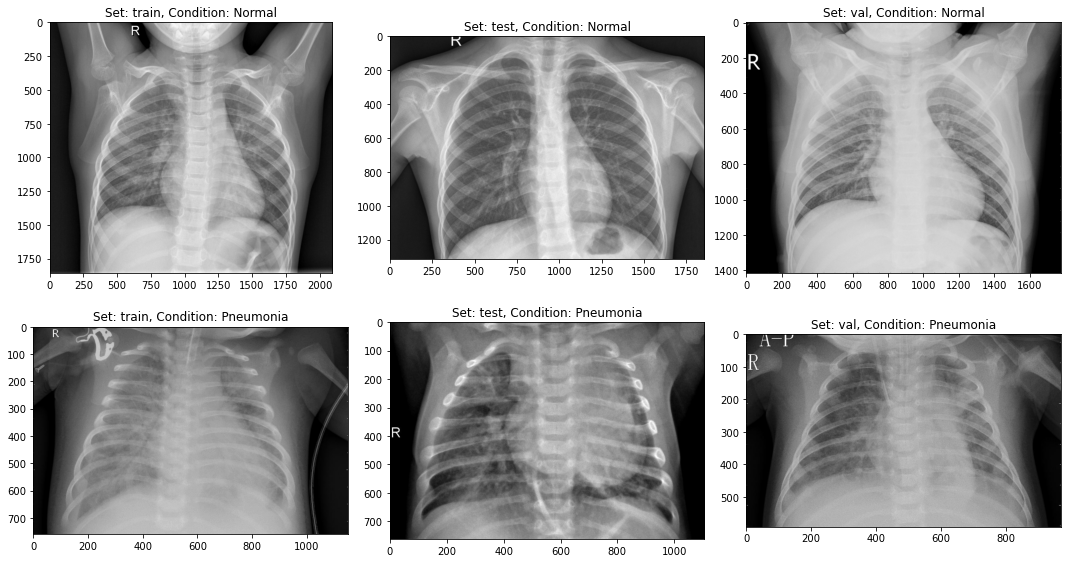

In [25]:
PATH ='/chest_xray/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15,8))
ax = ax.ravel()
plt.tight_layout()


for i, _set in enumerate(['train','test','val']):
    set_path = PATH + _set
    ax[i].imshow(cv2.imread(set_path+'/NORMAL/'+ os.listdir(set_path + '/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+ os.listdir(set_path + '/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))
    
    plt.savefig('condition.png', format='png')

In [3]:
for _set in ['train', 'test', 'val']:
    n_normal = len(os.listdir(PATH + _set + '/NORMAL'))
    n_infect = len(os.listdir(PATH + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: test, normal images: 234, pneumonia images: 390
Set: val, normal images: 8, pneumonia images: 8


In [4]:
def process_images(dims, batch_size=32):
    # data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       zoom_range=0.35,
                                       vertical_flip=True,validation_split=0.3)
    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(directory=PATH + 'train',
                                                  target_size=(dims, dims),
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=True,
                                                 subset='training')
    
    val_gen = val_datagen.flow_from_directory(directory=PATH + 'train',
                                             target_size=(dims, dims),
                                             batch_size=batch_size,
                                             class_mode='binary',
                                             shuffle=True,
                                             subset='validation')
    
    test_gen = test_datagen.flow_from_directory(directory=PATH+'test',
                                               target_size=(dims, dims),
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               shuffle=True)
    
    # making predictions of the test set in one batch size
    # this is useful to be able to get the confusion matrix
    
    test_data = []
    test_label = []
    
    for _set in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(PATH + 'test' + _set)):
            img = plt.imread(PATH + 'test' + _set + img)
            img = cv2.resize(img, (dims, dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32')/255
            if _set == '/NORMAL/':
                label = 0
            elif _set == '/PNEUMONIA/':
                label = 1
                
            test_data.append(img)
            test_label.append(label)
            
    test_data = np.array(test_data)
    test_label = np.array(test_label)
    
    return train_gen, val_gen, test_gen, test_data, test_label            

In [5]:
img_dims = 150
epochs = 10
batch_size=32
train_gen, val_gen, test_gen, test_data, test_label= process_images(img_dims, batch_size=batch_size)

Found 3652 images belonging to 2 classes.
Found 1564 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 148, 148, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 146, 146, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 48, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

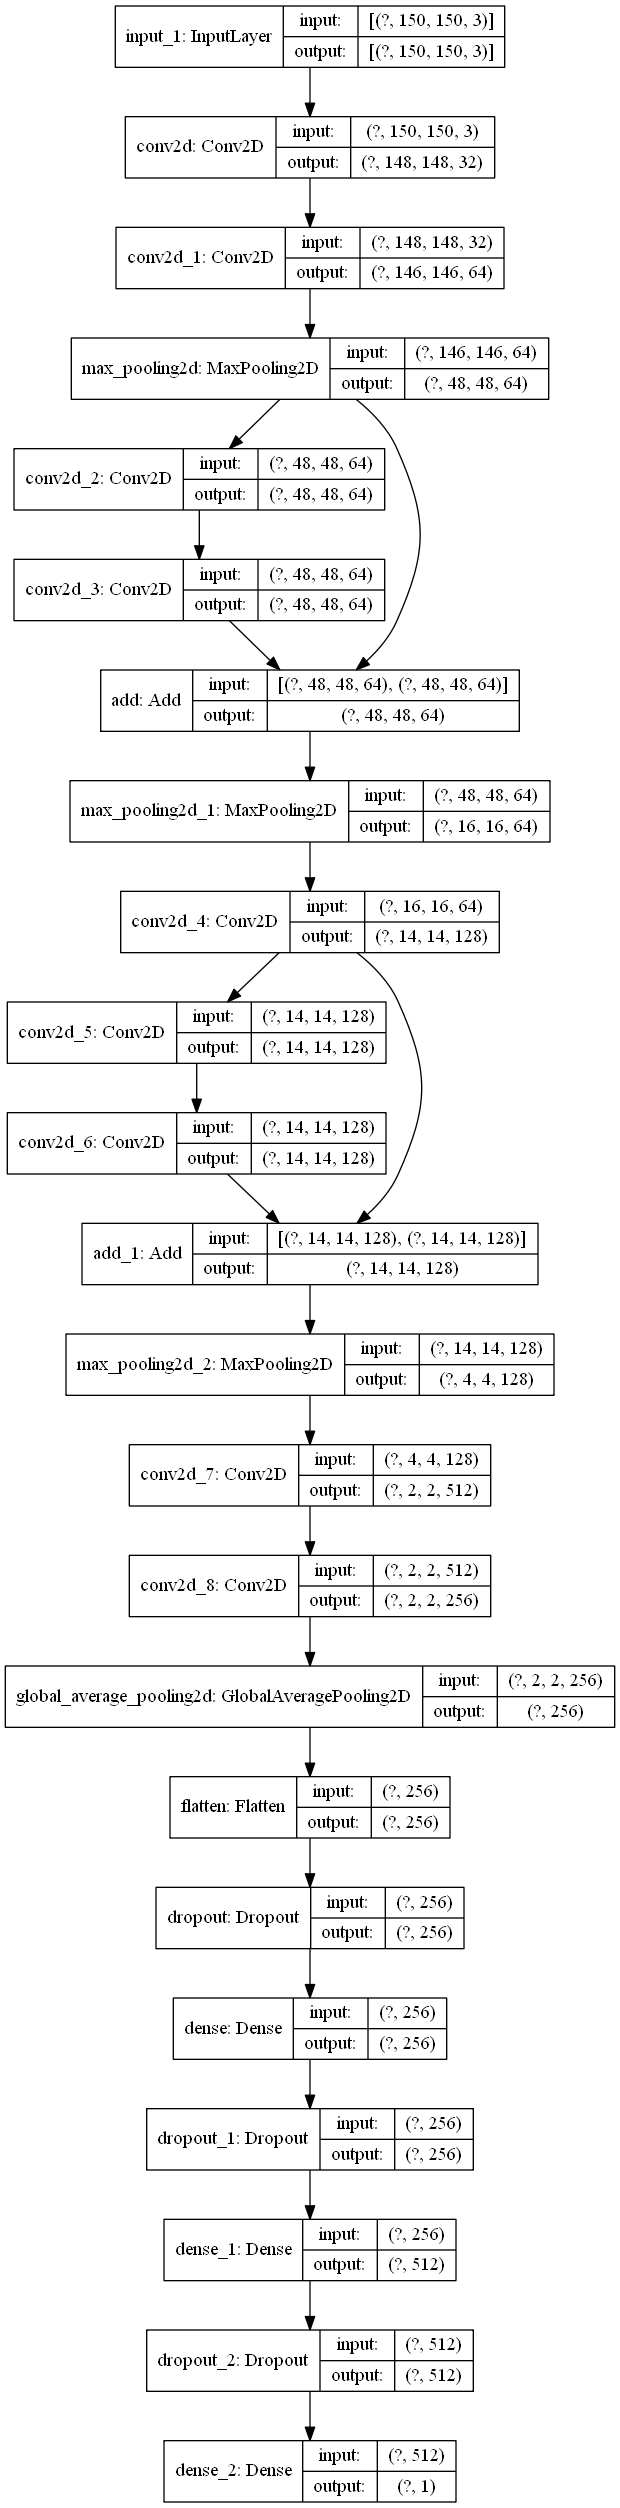

In [6]:
inputs = keras.Input(shape=(img_dims, img_dims, 3))

x = layers.Conv2D(32, kernel_size=3, activation='relu')(inputs)
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(block_1_output)
x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
x = layers.add([x, block_1_output])
x = layers.MaxPooling2D(3)(x)
block_2_output = layers.Conv2D(128, kernel_size=3, strides=1)(x)


x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(block_2_output)
x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
x = layers.add([x, block_2_output])
x = layers.MaxPooling2D(3)(x)
block_3_output = layers.Conv2D(512, kernel_size=3, strides=1)(x)

x = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.models.Model(inputs, outputs)
model.summary()


plot_model(model, show_shapes=True, to_file='residual.png')

In [7]:
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.BinaryCrossentropy(),
             metrics=[keras.metrics.BinaryAccuracy()])

In [8]:
# callbacks 
checkpoint = ModelCheckpoint(filepath='untitled_copy_v2', save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', patience=1, min_delta=0.1, mode='min')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=2, mode='max')

In [9]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
epochs = 20

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.n//batch_size,
                             epochs=epochs, validation_data=val_gen, validation_steps=val_gen.n//batch_size,
                             callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
114/114 [==============================] - 165s 1s/step - loss: 0.6083 - binary_accuracy: 0.7351 - val_loss: 0.4807 - val_binary_accuracy: 0.7461
Epoch 2/20
114/114 [==============================] - 159s 1s/step - loss: 0.4794 - binary_accuracy: 0.7768 - val_loss: 0.3335 - val_binary_accuracy: 0.8307
Epoch 3/20
114/114 [==============================] - 137s 1s/step - loss: 0.3521 - binary_accuracy: 0.8575 - val_loss: 0.3215 - val_binary_accuracy: 0.8555
Epoch 4/20
114/114 [==============================] - 127s 1s/step - loss: 0.3203 - binary_accuracy: 0.8765 - val_loss: 0.2796 - val_binary_accuracy: 0.8828
Epoch 5/20
114/114 [==============================] - 133s 1s/step - loss: 0.3011 - binary_accuracy: 0.8798 - val_loss: 0.2865 - val_binary_accuracy: 0.8783
Epoch 6/20
114/114 [==============================] - 131s 1s/step - loss: 0.3091 - binary_accuracy: 0.8892 - val_loss: 0.4099 - val_binary

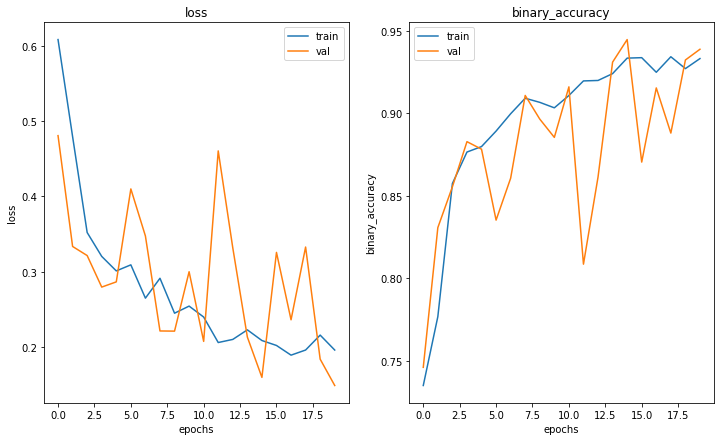

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax = ax.ravel()

for i, _set in enumerate(['loss', 'binary_accuracy']):
    ax[i].plot(history.history[_set])
    ax[i].plot(history.history['val_'+_set])
    ax[i].set_title(_set)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(_set)
    ax[i].legend(['train','val'])
    
plt.savefig('graph_residual.png', format='png')

In [11]:
model.evaluate_generator(val_gen, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
49/49 [==============================] - 14s 288ms/step - loss: 0.1471 - binary_accuracy: 0.9399


[0.14711643755435944, 0.9398977160453796]

In [12]:
model.evaluate_generator(test_gen, verbose=1)

20/20 [==============================] - 6s 287ms/step - loss: 0.3517 - binary_accuracy: 0.9022


[0.3517361879348755, 0.9022436141967773]

In [13]:
model.save('residual.h5')

In [14]:
predictions = model.predict_generator(test_gen, verbose=1)
predictions = np.round(predictions)
predictions

Instructions for updating:
Please use Model.predict, which supports generators.
20/20 [==============================] - 5s 248ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],

In [16]:
import pandas as pd

result = pd.DataFrame({'label':test_gen.labels,
                      'prediction':predictions.flatten()})

In [17]:
result.tail()

,label,prediction
619,1,1.0
620,1,1.0
621,1,1.0
622,1,0.0
623,1,1.0


In [18]:
result['label'].value_counts()

1    390
0    234
Name: label, dtype: int64

In [19]:
result['prediction'].value_counts()

1.0    431
0.0    193
Name: prediction, dtype: int64

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score

preds = model.predict(test_data, verbose=1)

acc = accuracy_score(test_label, np.round(preds))*100
cm = confusion_matrix(test_label, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print("-----CONFUSION MATRIX-----")
print(cm)

print("\n----METRICS----")

precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100

print("Accuracy: {} %".format(acc))
print("Precision: {} %".format(precision))
print("Recall: {} %".format(recall))
print("f1 score: {}".format(2*precision*recall/(precision+recall)))


20/20 [==============================] - 2s 90ms/step
-----CONFUSION MATRIX-----
[[184  50]
 [ 10 380]]

----METRICS----
Accuracy: 90.38461538461539 %
Precision: 88.37209302325581 %
Recall: 97.43589743589743 %
f1 score: 92.68292682926828


In [23]:
import pandas as pd

result = pd.DataFrame({'label':test_label,
                      'prediction':np.round(preds).flatten()})


result.head(50)

,label,prediction
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,1.0
8,0,1.0
9,0,0.0
